# Diagnosis library test 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.sat as sat
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag

In [2]:
1e-3/7e3*9.81

1.4014285714285714e-06

In [3]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.49:8787/status,
Dashboard: http://10.148.1.49:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.49:37106,Workers: 0
Dashboard: http://10.148.1.49:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


_______
## Load data

In [4]:
labels=cstes.labels

In [5]:
DS= {l: xr.open_zarr(cstes.zarr_dir+'/'+l+'.zarr').persist() for l in labels}
ds=DS[labels[2]]

In [6]:
ds

<xarray.Dataset>
Dimensions:                        (obs: 11960, site_obs: 1489, alti_time: 21,
                                    alti_time_mid: 20, box_y: 40, box_x: 80)
Coordinates: (12/19)
    alti_lat                       (obs, alti_time) float64 dask.array<chunksize=(500, 21), meta=np.ndarray>
    alti_lon                       (obs, alti_time) float64 dask.array<chunksize=(500, 21), meta=np.ndarray>
  * alti_time                      (alti_time) int64 0 1 2 3 4 ... 17 18 19 20
    alti_time_                     (obs, alti_time) datetime64[ns] dask.array<chunksize=(2990, 11), meta=np.ndarray>
  * alti_time_mid                  (alti_time_mid) float64 0.5 1.5 ... 18.5 19.5
    alti_x                         (obs, alti_time) float64 dask.array<chunksize=(500, 21), meta=np.ndarray>
    ...                             ...
    drifter_time                   (obs, site_obs) datetime64[ns] dask.array<chunksize=(748, 187), meta=np.ndarray>
    drifter_x                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                      (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    lat                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    time                           (obs) datetime64[ns] dask.array<chunksize=(11960,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs
Data variables: (12/61)
    __site_id                      (obs) object dask.array<chunksize=(11960,), meta=np.ndarray>
    __site_matchup_indice          (obs) int32 dask.array<chunksize=(500,), meta=np.ndarray>
    __site_name                    (obs) object dask.array<chunksize=(11960,), meta=np.ndarray>
    acc_x                          (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    acc_y                          (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    alti___distance                (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                             ...
    drifter_vn                     (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vx                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vy                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    f                              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    g_grad_sla                     (obs, alti_time_mid) float64 dask.array<chunksize=(500, 20), meta=np.ndarray>
    g_grad_sla_denoised            (obs, alti_time_mid) float64 dask.array<chunksize=(500, 20), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__argos
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

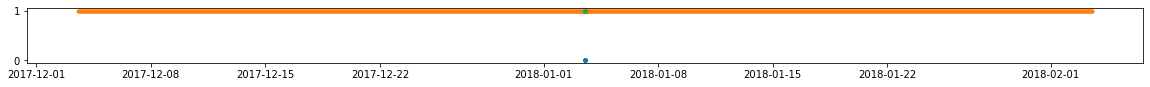

In [7]:
a=ds.isel(obs=0).alti_time_
d=ds.isel(obs=0).drifter_time
time=ds.isel(obs=0).time
smatchup=ds.drifter_time.isel(obs=0).isel(site_obs=ds.isel(obs=0).__site_matchup_indice.values)

plt.figure(figsize=(20, 1))
plt.scatter(a, np.zeros_like(a,dtype=int),marker='.', label='drifter time')
plt.scatter(d, np.ones_like(d, dtype=int),marker='.', label='matchup drifter time')
plt.scatter(smatchup, [1], marker='*', label='satellite time')
#plt.scatter(time, np.ones_like(time), marker='*')


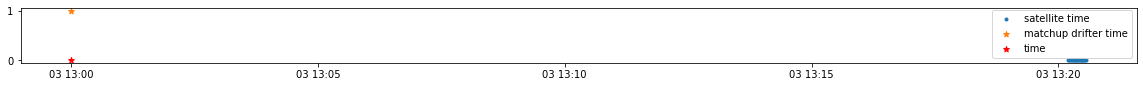

In [8]:
plt.figure(figsize=(20, 1))
plt.scatter(a, np.zeros_like(a,dtype=int),marker='.', label='satellite time')
plt.scatter(smatchup, [1], marker='*', label = 'matchup drifter time')
plt.scatter(time, [0], marker='*', color='r',label = 'time')
plt.legend()

____
## Define diagnosis functions

In [9]:
def diag_coloc_repartition(ds, bins, ds_diag):
    """ Count number of colocalisation in lon-lat bins and add it to the diagnosis dataset
    
    Parameters
    ----------
    ds : xarray Dataset
        dataset build by box.build_dataset
    bins : [np.array,np.array]
        [lon,lat]
    ds_diag : xarray Dataset
        diagnosis dataset in which we add new diagnosis
    """
    
    ds_diag['coloc_repartition'] = histogram(ds.lon, ds.lat, bins=bins).compute()



def diag_ind_pdfs(ds, bins, ds_diag):   
    """ Compute and add to the diagnosis dataset independant pdf of the acceleration's, coriolis's terms for both x-along track and y-orthogonal direction and pressure gradient's term on both x-along track 
    If the given bin is np.ndarray, it returns the pdfs of the flatten ds, if the given bin is a dictionnary, the pdfs will be computed along dict dimensions. 
    
    Parameters
    ----------
    ds : xarray Dataset
        dataset build by box.build_dataset
    bins : np.ndarray or dict('dim':ndarray)
    ds_diag : xarray Dataset
        diagnosis dataset in which we add new diagnosis
    """
    
    # bins = dict(acc=bins_acc, separation=bins_separation)
    
    #Acceleration
    dt=3600
    if isinstance(bins, dict):
        #_ds = ds.sel(site_obs = ds.__site_matchup_indice.compute)
        
        ds_diag['pdf_acc_x'] = histogram(ds['acc_x'].rename('acc'), *[ds[k] for k in bins if k!='acc'], bins=[v for k, v in bins.items()], density=True).compute()#dtvx
        ds_diag['pdf_acc_y'] = histogram(ds['acc_y'].rename('acc'), *[ds[k] for k in bins if k!='acc'], bins=[v for k, v in bins.items()], density=True).compute()#dtvy
        
        ds_diag['pdf_coriolis_x'] = histogram(ds['coriolis_x'].rename('acc'), *[ds[k] for k in bins if k!='acc'], bins=[v for k, v in bins.items()], density=True).compute()
        ds_diag['pdf_coriolis_y'] = histogram(ds['coriolis_y'].rename('acc'), *[ds[k] for k in bins if k!='acc'], bins=[v for k, v in bins.items()], density=True).compute()
        
        ds_diag['pdf_g_grad_sla'] = histogram(ds['g_grad_sla'].rename('acc'), *[ds[k] for k in bins if k!='acc'], bins=[v for k, v in bins.items()], density=True).compute()
        ds_diag['pdf_g_grad_sla_denoised'] = histogram(ds['g_grad_sla_denoised'].rename('acc'), *[ds[k] for k in bins if k!='acc'], bins=[v for k, v in bins.items()], density=True).compute()
        
    elif isinstance(bins, np.ndarray):
        ds_diag['pdf_acc_x'] = histogram(ds['acc_x'].rename('acc'), bins=bins,density=True).compute()#dtvx
        ds_diag['pdf_acc_y'] = histogram(ds['acc_y'].rename('acc').rename('acc'), bins=bins,density=True).compute()#dtvy

        #Coriolis
        ds_diag['pdf_coriolis_x'] = histogram(ds['coriolis_x'].rename('acc'), bins=bins,density=True).compute()
        ds_diag['pdf_coriolis_y'] = histogram(ds["coriolis_y"].rename('acc'), bins=bins,density=True).compute()

        #Pressure gradient
        _ds = ds.isel(site_obs=ds.__site_matchup_indice.compute(), alti_time=10, alti_time_mid=10)
        ds_diag['pdf_g_grad_sla'] = histogram(_ds["g_grad_sla"].rename('acc'), bins=bins,density=True).compute()
        ds_diag['pdf_g_grad_sla_denoised'] = histogram(_ds["g_grad_sla_denoised"].rename('acc'), bins=bins,density=True).compute()
    else : 
        print('wrong bins type')

def diag_combined_pdfs(ds, bins, ds_diag):
    """ Compute and add to the diagnosis dataset combined pdfs of the coriolis's + pressure gradient's terms and acceleration's + coriolis's and pressure gradient's terms on x-along track direction. 
    If the given bin is np.ndarray, it returns the pdfs of the flatten ds, if the given bin is a dictionnary, the pdfs will be computed along dict dimensions. 
    
    Parameters
    ----------
    ds : xarray Dataset
        dataset build by box.build_dataset
    bins : np.ndarray or dict('dim':ndarray)
    ds_diag : xarray Dataset
        diagnosis dataset in which we add new diagnosis
    """
    if isinstance(bins, dict):
        ds_diag['pdf_cor_grad_x']= histogram((ds['coriolis_x']+ds["g_grad_sla_denoised"]).rename('acc'),
                                             *[ds[k] for k in bins if k!='acc'],
                                             bins=[v for k, v in bins.items()],
                                             density=True).compute()
        #Coriolis+pressure gradient+acc along x
        dt=3600
        ds_diag['pdf_comb_x']=histogram((ds['coriolis_x']+ds["g_grad_sla_denoised"]+(ds['acc_x'])).rename('acc'),
                                        *[ds[k] for k in bins if k!='acc'],
                                        bins=[v for k, v in bins.items()],
                                        density=True).compute()


    elif isinstance(bins, np.ndarray):
        #Coriolis+pressure gradient
        _ds = ds.isel(site_obs=ds.__site_matchup_indice.compute(), alti_time=10, alti_time_mid=10)
    
        ds_diag['pdf_cor_grad_x']= histogram((_ds['coriolis_x']+_ds["g_grad_sla_denoised"]).rename('acc'), bins=bins,density=True).compute()
        #Coriolis+pressure gradient+acc along x
        dt=3600
        ds_diag['pdf_comb_x']=histogram((_ds['coriolis_x']+_ds["g_grad_sla_denoised"]+_ds['acc_x']).rename('acc'), bins=bins,density=True).compute()
    else : 
        print('wrong bins type')


    
def diags(ds, diag_list, bins_list):
    """ Compute and add several diagnosis to the diagnosis dataset
    
    Parameters
    ----------
    ds : xarray Dataset
        data dataset, for example dataset built by box.build_dataset
    diag_list : list of diagnosis functions we want to add to the diagnosis function
    bins_list : list of np.ndarray or dict('dim':ndarray)
        bins for the diagnosis functions in diag_list
    """
    
    ds_diag=xr.Dataset()
    #Number of colocalisations in ds (will be used as weight combining different colocalisation type)
    ds_diag['nb_coloc'] = ds.sizes['obs']
    for i in range(len(bins_list)):
        diag_list[i](ds,bins_list[i],ds_diag)
    return ds_diag

def DS_Diag(DS, diag_list, bins_list):
    """ Concatenate the diagnosis datasets of the different colocalisation type 'drifter_sat_year' in one dataset
    
    Parameters
    ----------
    ds : xarray Dataset
        data dataset, for example dataset built by box.build_dataset
    diag_list : list of diagnosis functions we want in the diagnosis dataset
    bins_list : list or np.array
        bins for the diagnosis functions in diag_list
    """
    
    DS_diag = xr.concat([diags(DS[key], diag_list, bins_list) for key in DS], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
    return DS_diag


_____
## Apply diagnosis

In [10]:
dl = 2
lon, lat = np.arange(-180, 180, dl), np.arange(-90,90,dl)
acc_bins=np.arange(-1e-4,1e-4,1e-6)

diag_list = [diag.diag_coloc_repartition,diag.diag_ind_pdfs, diag.diag_combined_pdfs]
bins_list = [[lon,lat]]+[acc_bins]*2

In [11]:
DS_diag = diag.DS_Diag(DS, diag_list, bins_list)

In [12]:
DS_diag

<xarray.Dataset>
Dimensions:                  (drifter_sat_year: 5, lon_bin: 179, lat_bin: 89,
                              acc_bin: 200)
Coordinates:
  * lon_bin                  (lon_bin) float64 -179.0 -177.0 ... 175.0 177.0
  * lat_bin                  (lat_bin) float64 -89.0 -87.0 -85.0 ... 85.0 87.0
  * acc_bin                  (acc_bin) float64 -9.95e-05 -9.85e-05 ... 9.95e-05
  * drifter_sat_year         (drifter_sat_year) object 'gps_SARAL_2018' ... '...
Data variables:
    nb_coloc                 (drifter_sat_year) int64 74235 73334 ... 12077 4054
    coloc_repartition        (drifter_sat_year, lon_bin, lat_bin) int64 0 ... 0
    pdf_acc_x                (drifter_sat_year, acc_bin) float64 4.13 ... 15.91
    pdf_acc_y                (drifter_sat_year, acc_bin) float64 4.045 ... 36.97
    pdf_coriolis_x           (drifter_sat_year, acc_bin) float64 75.69 ... 68.35
    pdf_coriolis_y           (drifter_sat_year, acc_bin) float64 39.19 ... 46.88
    pdf_g_grad_sla           (drifter_sat_year, acc_bin) float64 683.0 ... 501.1
    pdf_g_grad_sla_denoised  (drifter_sat_year, acc_bin) float64 67.62 ... 0.0
    pdf_cor_grad_x           (drifter_sat_year, acc_bin) float64 189.8 ... 247.5
    pdf_comb_x               (drifter_sat_year, acc_bin) float64 54.23 ... 0.0

## Bins pdf + distance to the matchup site

In [35]:
acc_bins=np.arange(-1e-4,1e-4,2e-6)
dist_bins=np.arange(0,1e5,2e3)
diag_list = [diag.diag_ind_pdfs, diag.diag_combined_pdfs]
bins_list = [ {"acc": acc_bins, "alti___distance" : dist_bins} ]*2
                

ds_diag_dist = xr.concat([diag.diags(DS[key].isel( site_obs = DS[key].__site_matchup_indice.compute() )
                                .isel(alti_time=10)
                                .isel(alti_time_mid=10),
                                diag_list, bins_list) for key in DS],
                         dim=pd.Index(DS.keys(),name='drifter_sat_year'))

In [36]:
ds_diag_dist

<xarray.Dataset>
Dimensions:                  (drifter_sat_year: 5, acc_bin: 100,
                              alti___distance_bin: 49)
Coordinates:
  * acc_bin                  (acc_bin) float64 -9.9e-05 -9.7e-05 ... 9.9e-05
  * alti___distance_bin      (alti___distance_bin) float64 1e+03 ... 9.7e+04
  * drifter_sat_year         (drifter_sat_year) object 'gps_SARAL_2018' ... '...
Data variables:
    nb_coloc                 (drifter_sat_year) int64 74235 73334 ... 12077 4054
    pdf_acc_x                (drifter_sat_year, acc_bin, alti___distance_bin) float64 ...
    pdf_acc_y                (drifter_sat_year, acc_bin, alti___distance_bin) float64 ...
    pdf_coriolis_x           (drifter_sat_year, acc_bin, alti___distance_bin) float64 ...
    pdf_coriolis_y           (drifter_sat_year, acc_bin, alti___distance_bin) float64 ...
    pdf_g_grad_sla           (drifter_sat_year, acc_bin, alti___distance_bin) float64 ...
    pdf_g_grad_sla_denoised  (drifter_sat_year, acc_bin, alti___distance_bin) float64 ...
    pdf_cor_grad_x           (drifter_sat_year, acc_bin, alti___distance_bin) float64 ...
    pdf_comb_x               (drifter_sat_year, acc_bin, alti___distance_bin) float64 ...

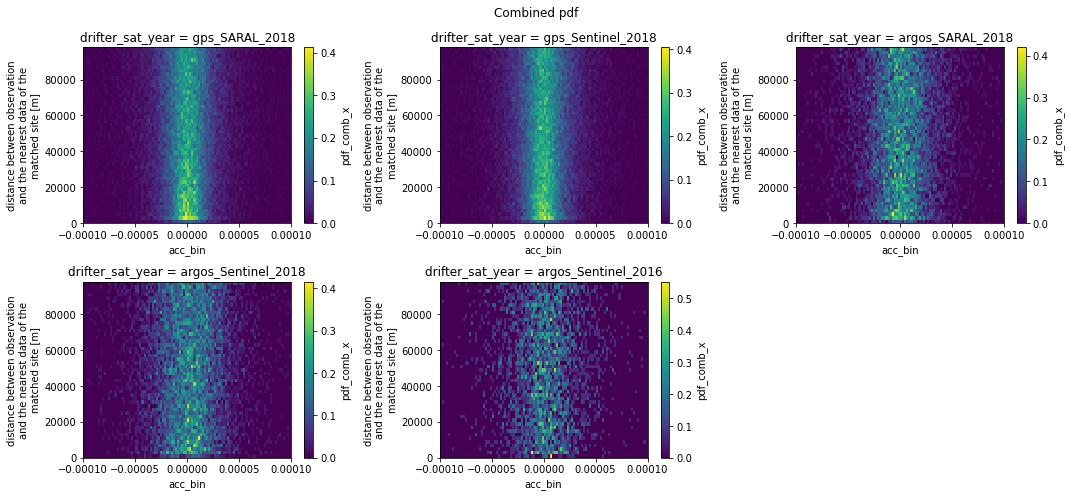

In [37]:
n=len(ds_diag_dist['drifter_sat_year'])
fig = plt.figure(figsize=(15,7))
for i in range(n):
    ax = fig.add_subplot(2,int(np.ceil(n/2)),i+1)
    ds_diag_dist.pdf_comb_x.isel(drifter_sat_year=i).plot(x='acc_bin', y='alti___distance_bin', ax=ax)
fig.suptitle("Combined pdf")
fig.tight_layout()

## Add mean, std, and quartil values

In [60]:
def DS_mean_std_quartile(ds_pdf, bin_dim):
     """ Return dataset containing mean, variance, std for all pdfs in the given dataset
    
    Parameters
    ----------
    ds_pdf : xarray Dataset
        dataset containing pdfs built by diags
    bin_dim : str
        bin dimension name
    """
    list_pdf_name = [l.replace('pdf','') for l in list(ds_pdf.keys()) if 'pdf' in l]
    _ds=xr.Dataset()
    for name in list_pdf_name :
        rescale=ds_pdf['pdf'+name].integrate(coord=bin_dim)
        _ds['mean' + name]= (ds_pdf[bin_dim]*ds_pdf['pdf' + name]).integrate(coord=bin_dim)/rescale
        _ds['var' + name]=((ds_pdf[bin_dim]-_ds['mean' + name])**2*ds_pdf['pdf' + name]
                                 ).integrate(coord = bin_dim)/rescale
                                 
        _ds['std' + name]=np.sqrt(_ds['var' + name]
                                 )
        
    return _ds


In [61]:
ds = DS_mean_std_quartile(ds_diag_dist, 'acc_bin')
ds

<xarray.Dataset>
Dimensions:                   (alti___distance_bin: 49, drifter_sat_year: 5)
Coordinates:
  * alti___distance_bin       (alti___distance_bin) float64 1e+03 ... 9.7e+04
  * drifter_sat_year          (drifter_sat_year) object 'gps_SARAL_2018' ... ...
Data variables: (12/24)
    mean_acc_x                (drifter_sat_year, alti___distance_bin) float64 ...
    var_acc_x                 (drifter_sat_year, alti___distance_bin) float64 ...
    std_acc_x                 (drifter_sat_year, alti___distance_bin) float64 ...
    mean_acc_y                (drifter_sat_year, alti___distance_bin) float64 ...
    var_acc_y                 (drifter_sat_year, alti___distance_bin) float64 ...
    std_acc_y                 (drifter_sat_year, alti___distance_bin) float64 ...
    ...                        ...
    mean_cor_grad_x           (drifter_sat_year, alti___distance_bin) float64 ...
    var_cor_grad_x            (drifter_sat_year, alti___distance_bin) float64 ...
    std_cor_grad_x            (drifter_sat_year, alti___distance_bin) float64 ...
    mean_comb_x               (drifter_sat_year, alti___distance_bin) float64 ...
    var_comb_x                (drifter_sat_year, alti___distance_bin) float64 ...
    std_comb_x                (drifter_sat_year, alti___distance_bin) float64 ...

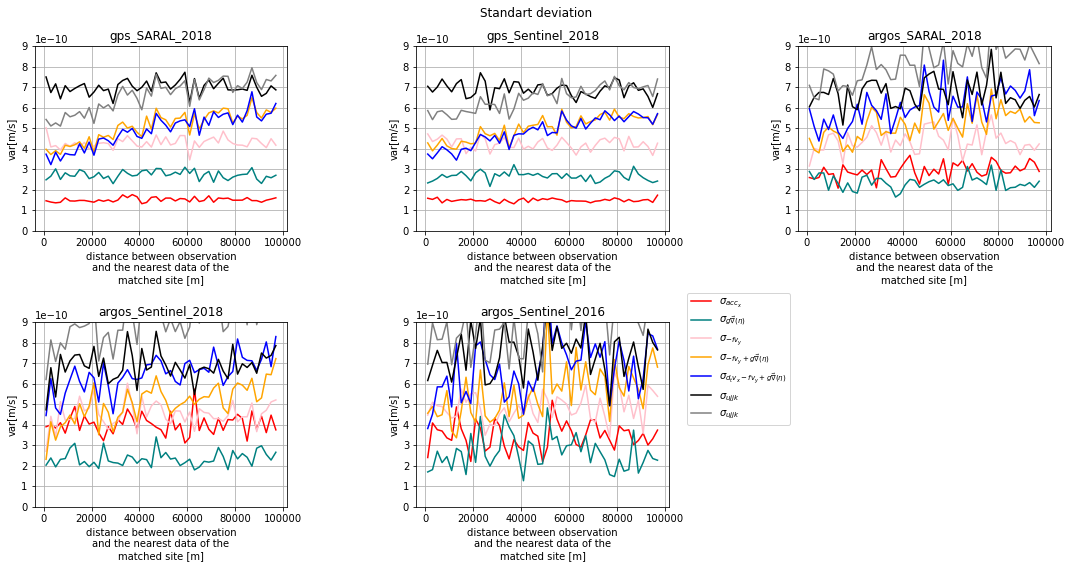

In [69]:
fig = plt.figure(figsize=(15,8))
j=0
n=len(ds['drifter_sat_year'])
for i in range (n):
    __ds=ds.isel(drifter_sat_year = i)
    ax = fig.add_subplot(2,int(np.ceil(n/2)),j+1)
    __ds.var_acc_x.plot( color='red', label=r"$\sigma_{acc_x}$", ax=ax)
    __ds.var_g_grad_sla_denoised.plot( color='teal', label=r"$\sigma_{g\vec{\nabla}(\eta)}$", ax=ax)
    __ds.var_coriolis_x.plot( color='pink', label=r"$\sigma_{-fv_y}$", ax=ax)
    __ds.var_cor_grad_x.plot( color='orange', label=r"$\sigma_{-fv_y+g\vec{\nabla}(\eta)}$", ax=ax)
    __ds.var_comb_x.plot( color='b', label=r"$\sigma_{d_tv_x-fv_y+g\partiel_x\eta}$", ax=ax)
    (__ds.var_coriolis_x+__ds.var_g_grad_sla_denoised).plot( color='k', label=r"$\sigma_{ujjk}$", ax=ax)
    (__ds.var_cor_grad_x+__ds.var_acc_x).plot( color='grey', label=r"$\sigma_{ujjk}$", ax=ax)
    ax.set_title(ds.drifter_sat_year.values[i])
    j+=1
    ax.grid()
    ax.set_ylabel('var[m/s]')
    ax.set_ylim(0,9e-10)
ax.legend(loc='center right',bbox_to_anchor=(1.5, 0.8))

fig.suptitle(r"Standart deviation")
fig.tight_layout()

## Join pdf
https://pythonhosted.org/prob140/joint_tutorial.html
https://seaborn.pydata.org/generated/seaborn.jointplot.html